# [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/)
> Track healthy organs in medical scans to improve cancer treatment

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25">

# Methodology
* In this notebook, I'll demonstrate how to create dataset from **run_length_encode** mask. 
* As it takes quite some to convert **rle** masks to **seantic** masks on-fly, we'll pre-computed the **semantic** masks and save them to avoid **bottleneck** during training.
* I"ll also be using **Weights & Biases** for interactive visualization.

# Notebooks
📌 **2.5D-TransUnet**:
* Train: [UWMGI: TransUNet 2.5D [Train] [TF]](https://www.kaggle.com/code/awsaf49/uwmgi-transunet-2-5d-train-tf)

📌 **2.5D**:
* Train: [UWMGI: 2.5D [Train] [PyTorch]](https://www.kaggle.com/awsaf49/uwmgi-2-5d-train-pytorch/)
* Infer: [UWMGI: 2.5D [Infer] [PyTorch]](https://www.kaggle.com/awsaf49/uwmgi-2-5d-infer-pytorch/)
* Data: [UWMGI: 2.5D stride=2 Data](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-stride-2-data/)
* Dataset: [UWMGI: 2.5D stride=2 Dataset](https://www.kaggle.com/datasets/awsaf49/uwmgi-25d-stride2-dataset)

📌 **UNet**:
* Train: [UWMGI: Unet [Train] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch/)
* Infer: [UWMGI: Unet [Infer] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-unet-infer-pytorch/)

📌 **MMDetection**:
* Train: [UWMGI: MMDetection [Train]](https://www.kaggle.com/code/awsaf49/uwmgi-mmdetection-train)

📌 **Data/Dataset**:
* Data: [UWMGI: Mask Data](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-data)
* Dataset: [UWMGI: Mask Dataset](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-dataset)

# Install Libraries

In [1]:
!pip install wandb --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 11.9 MB/s 
     |████████████████████████████████| 145 kB 34.2 MB/s 
     |████████████████████████████████| 181 kB 68.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=8d525121c1f481258a6ef5281b1d06d790056bd8da82c40d1bcfa4b179b54229
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import tensorflow as tf

# WandB

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of **W&B**:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.

How to find `WANDB_API_KEY`?
1. Login to [wandb.ai](https://wandb.ai/login).
2. Goto your [Settings](https://app.wandb.ai/settings) Page.
3. Scroll down and select `NEW_KEY`  in `API keys` tab.

In [2]:
import wandb

wandb.init(project="test-project", entity="gamchat")

try:
    wandb.login(key='c54e6710bfe3045cd82ea17ee00e4ca8d2580876')
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Currently logged in as: jennyj (gamchat). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [3]:
import os
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/open_directory/test/IMAGE')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/open_directory/test/IMAGE


# Configs

In [4]:
NUM_LOG = 1000 # for WandB interactive Visualiztion
NO_EMPTY = True # set False to include images with empty mask in WandB

# Utilities

## RLE

In [5]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):  # 길이 복호화(문자열 -> np.array)
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):  #길이(runlength) 부호화 (np.array -> 문자열)
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


## Metadata

In [6]:
def get_metadata(row):  # id통해 case, day, slice 만들기
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']  # 경로 통해서 height/ width/ case/ day/ slice 만들기
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

## Mask

In [7]:
def id2mask(id_, df=None):
    idf = df[df['id']==id_] # id 같은것만
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)  # (h, w, 3)
    mask = np.zeros(shape, dtype=np.uint8)  # 높이, 너비만큼의 0행렬 만들어서
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

## Image

In [8]:
def load_img(path): # unit16(0 ~ 65535) -> unit8 그냥 바꾸면 안됨. uint8(0~255 : RGB 에서 사용하는 타입데이터) 손실 방지하기 위해 정규화를 거쳐야 함.이미지 불러와서 실수로 변환, 0~255 값으로 스케일 해주고 변환 
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # 히스토그램을 활용하여 이미지의 품질을 개선하기 위함. 히스토그램 균등화. tileGridSize=(8,8) 격자 사용해서 각 사각형을 화질 등 품질 균등하게
    img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

# Meta Data

## Train

In [9]:
df = pd.read_csv('./dataset/uw-madison-gi-tract-image-segmentation/train.csv')
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [10]:
df = df.progress_apply(get_metadata, axis=1)  # case, dat, slice 만들기.
df.head()

  0%|          | 0/115488 [00:00<?, ?it/s]

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1
2,case123_day20_slice_0001,stomach,NaN,123,20,1
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2


## Path

In [11]:
import pickle
with open('all_train_images.pickle', 'rb') as f:
    paths = pickle.load(f)
path_df = pd.DataFrame(paths, columns=['image_path']) # image_path 컬럼 데이터 프레임을 만든다.
path_df = path_df.progress_apply(path2info, axis=1) # 경로 통해서 height/ width/ case/ day/ slice 만들기
df = df.merge(path_df, on=['case','day','slice']) # case, day, slice를 기준으로 두 데이터 프레임을 합친다.
df.head() # 여기에 mask_path도 넣어줄거다.

  0%|          | 0/38496 [00:00<?, ?it/s]

,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,./dataset/uw-madison-gi-tract-image-segmentati...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,./dataset/uw-madison-gi-tract-image-segmentati...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,1,./dataset/uw-madison-gi-tract-image-segmentati...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,./dataset/uw-madison-gi-tract-image-segmentati...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,./dataset/uw-madison-gi-tract-image-segmentati...,266,266


In [12]:
df.shape

(115488, 9)

In [13]:
115671/3

38557.0

# Check Mask

In [34]:
for id_ in df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[:4]:
  print(id_)

case66_day34_slice_0120
case119_day25_slice_0078
case143_day18_slice_0042
case122_day25_slice_0068


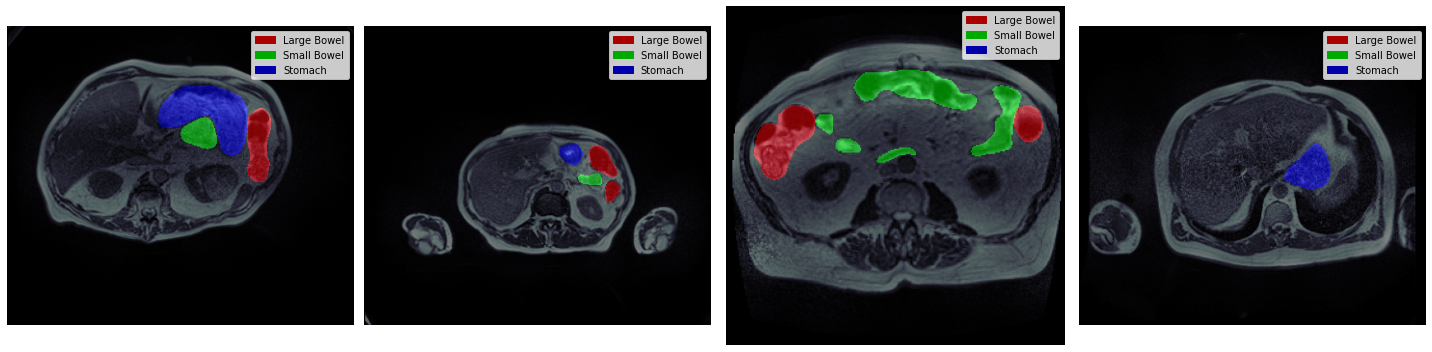

In [14]:
row=1; col=4
plt.figure(figsize=(5*col,5*row)) # 20*5
for i, id_ in enumerate(df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[:row*col]): # 4개 랜덤하게 샘플링합니다. 조건절의 ~표시는 not을 의미. seg결측값이 없는 곳에서만 sample
    img = load_img(df[df['id']==id_].image_path.iloc[0])  # 변수 id_에 해당하는 이미지를 불러옵니다. 노멀라이즈하고 unit8(RGB)로 수치 변환합니다. 
    mask = id2mask(id_,df=df)*255 # id_에 일치하는 이미지의 마스크를 만듭니다. (266, 266, 3) 슬라이스 사이즈에 맞춥니다.
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)  # 히스토그램 균등화를 통해 이미지 품질을 상승. (8,8) 격자.
    plt.tight_layout()

# Initiate **Wandb** Project

In [15]:
# Initialize WANDB project 새로 하위 프로젝트 폴더를 만듭니다.
run = wandb.init(project='uwmgi-mask-data', 
                 config={},
#                  anonymous=anonymous,
                 name=f"mask-data-noresize-v2",
                )
# Columns for wandb table
columns=["id", "case", "day", "slice", "empty", "image"]
# Initialize table
table = wandb.Table(columns=columns)
# Labels for mask
class_labels = {
#     0:"Background",
    1:"Large Bowel",
    2:"Small Bowel",
    3:"Stomach",
}

# Write Mask

In [43]:
a= './dataset/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'
a = a.replace('/dataset/','/tmp/png/')
a =a.rsplit('/',1)[0]
a

'./tmp/png/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans'

In [44]:
b= './dataset/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'
b=b.replace('/dataset/','/tmp/np/').replace('.png','.npy')
b

'./tmp/np/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.npy'

In [46]:
def save_mask(id_,df=None, count=0): # 경로 바꾸고 마스크 만들고 npy형태로 저장 266,266,3 -> 160, 192로 변환
    idf = df[df['id']==id_]
    mask = id2mask(id_, df=df) # mask from [0, 1] to [0, 255] # h, w, 3 형태로 만듭니다.
    image_path = idf.image_path.iloc[0]
    img = load_img(image_path) # load image
    mask_path = image_path.replace('/dataset/','/tmp/png/')
    mask_folder = mask_path.rsplit('/',1)[0]  # .../scans까지
    os.makedirs(mask_folder, exist_ok=True) # /tmp/png/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans
    cv2.imwrite(mask_path, mask*255, [cv2.IMWRITE_PNG_COMPRESSION, 1]) # write mask as .png 새로 만든 경로에 이미지를 작성한다.
    mask_path2 = image_path.replace('/dataset/','/tmp/np/').replace('.png','.npy')
    mask_folder2 = mask_path2.rsplit('/',1)[0]
    os.makedirs(mask_folder2, exist_ok=True)
    np.save(mask_path2, mask*255) # write mask as .npy 새로 만든 경로에 .npy 형태로 저장한다.
    # log each image in WandB table
    if count<=NUM_LOG:  # NUM_LOG = 1000
        img = cv2.resize(img, dsize=(160, 192), interpolation=cv2.INTER_AREA) # (266, 266, 3)이었는데 scale transformation  (160, 192)로 축소시킨다. 정보를 추출해서 결과 이미지 축소 셋팅.
        mask = cv2.resize(mask, dsize=(160, 192), interpolation=cv2.INTER_NEAREST)
        table.add_data(id_, 
                       idf.case.iloc[0], 
                       idf.day.iloc[0],
                       idf.slice.iloc[0],
                       int(mask.sum()==0),
                       wandb.Image(img, masks={
    #         "predictions" : {
    #             "mask_data" : prediction,
    #             "class_labels" : class_labels
    #         },
            "ground_truth" : {
                "mask_data" : rgb2gray(mask), # (height, width, 3) => (height, width) => may lose overlap data
                "class_labels" : class_labels
            }}))
    return mask_path

In [ ]:
[10<age<20] [age.between(10,20)]

In [17]:
tmp_df = df.copy()
if NO_EMPTY:  # NO_EMPTY == True라면 seg에서 결측값 이미지는 포함하지 않는다.
    tmp_df = tmp_df[~df.segmentation.isna()]  # 조건절의 ~은 not
ids = tmp_df['id'].unique()
# Save Mask. 변수 사용하려는 곳에 언더바 사용. 변수 없어도 된다는 의미.
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_, df=tmp_df, count=i)\
                                             for i, id_ in enumerate(tqdm(ids, total=len(ids))))
# 1. Parallel 인스턴스를 worker 몽땅 사용해 동작하게 만든다.

# 2. delayed를 사용해 튜플로 된 리스트를 만든다. 리스트 [(save_mask)(id_, df=tmp_df, count=i) for i, id_ in enumerate(tqdm(ids, total=len(ids)]를 생성한다.

# 3. 생성한 리스트를 Parallel 인스턴스로 pass 한다. 많은 양의 데이터를 병렬 처리


  0%|          | 0/16590 [00:00<?, ?it/s]

In [45]:
len(ids)

16590

# Log & Display **WandB** Table

In [18]:
# Log table to WandB
wandb.log({"Table":table})
# Finish The Run
wandb.finish()
# Display the Run
display(ipd.IFrame(run.url, width=1000, height=720))

# Access **WandB** tables

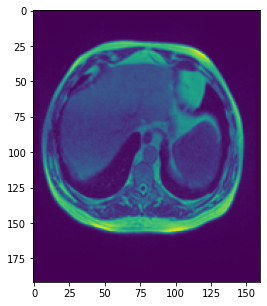

In [47]:
with wandb.init(project='uwmgi-mask-data') as run2:
    table2= run2.use_artifact(f"run-{run.id}-Table:v0").get("Table")
    
for idx, row in table2.iterrows():
    break
plt.figure(figsize=(5,5))
plt.imshow(np.array(row[-1].image))
# plt.imshow(row[1]._masks["ground_truth"]._val["mask_data"].astype('uint8')*255)

# Check Saved Mask

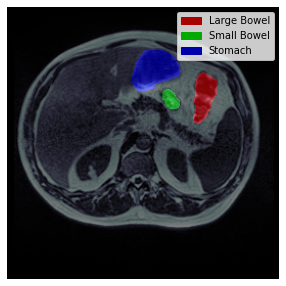

In [28]:
i = 250
img = load_img(df.image_path.iloc[i])
mask_path = df['image_path'].iloc[i].replace('/dataset/','/tmp/png/')
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(5,5))
show_img(img, mask=mask)

In [48]:
df

,id,class,segmentation,case,day,slice,image_path,height,width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/png/uw-madison-gi...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/png/uw-madison-gi...
2,case123_day20_slice_0001,stomach,NaN,123,20,1,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/png/uw-madison-gi...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/png/uw-madison-gi...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/png/uw-madison-gi...
...,...,...,...,...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,30,0,143,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/png/uw-madison-gi...
115484,case30_day0_slice_0143,stomach,NaN,30,0,143,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/png/uw-madison-gi...
115485,case30_day0_slice_0144,large_bowel,NaN,30,0,144,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/png/uw-madison-gi...
115486,case30_day0_slice_0144,small_bowel,NaN,30,0,144,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/png/uw-madison-gi...


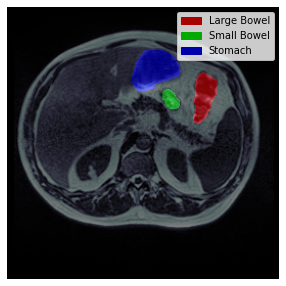

In [29]:
i = 250
img = load_img(df.image_path.iloc[i])
mask_path = df['image_path'].iloc[i].replace('/dataset/','/tmp/np/').replace('.png','.npy')
mask = np.load(mask_path)
plt.figure(figsize=(5,5))
show_img(img, mask=mask)

# Save Metadata

In [31]:
df2 = pd.read_csv('train.csv')
df2['mask_path'][1]

'/kaggle/input/uwmgi-mask-dataset/png//uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'

In [32]:
df['mask_path'] = df.image_path.str.replace('/dataset/','/dataset/uwmgi-mask-dataset/png/')
df.to_csv('train1.csv',index=False)

In [33]:
df2 = pd.read_csv('train1.csv')
df2['mask_path'][1]

'./dataset/uwmgi-mask-dataset/png/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'

# Compress Files

In [ ]:
shutil.make_archive('/kaggle/working/png',
                    'zip',
                    '/tmp/png',
                    'uw-madison-gi-tract-image-segmentation')

'/kaggle/working/png.zip'

In [ ]:
shutil.make_archive('/kaggle/working/np',
                    'zip',
                    '/tmp/np',
                    'uw-madison-gi-tract-image-segmentation')

'/kaggle/working/np.zip'